In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from pathlib import Path
import multiprocessing as mp
import json
from dataclasses import fields, MISSING

from modules.numeric import *
from modules.plotting import *
from modules.parallel import *

In [3]:
plt.rcParams['axes.labelsize'] = 14
cmap = get_cmap()

In [14]:
spath = Path('data/mosaic/')
session_path = spath/'session-'
with open(session_path/INFO_FILE, 'w') as json_file:
    json.dump({field.name:(field.default if not field.name == 'session_path' else str(session_path)) for field in fields(CollisionSession)}, json_file)

In [21]:
def read_path_info(path: Path) -> dict[str, float]:
    return dict(zip(FPARAMS, map(float, path.stem.split('-'))))

def get_summary(session_path: Path) -> pd.DataFrame:
    summary = []
    info = []
    for session in session_path.glob('session-*'):
        summary.append(pd.DataFrame([{'path':path, **read_path_info(path)} for path in session.glob('*.csv')]))
        with open(session/'session-info.json', 'r') as json_file:
            info.append(pd.Series(json.loads(json_file.read())))
        
    return summary, info

(summary, ), (info, ) = get_summary(Path('data/mosaic/'))
summary

,path,v,lamb,exec_time,delay
0,data/mosaic/session-/0.3540133779264214-15.603...,0.354013,15.603512,6212.099242,21.960698
1,data/mosaic/session-/0.25016722408026754-6.753...,0.250167,6.753930,5162.126230,28.683505
2,data/mosaic/session-/0.21103678929765884-15.77...,0.211037,15.770485,3709.034960,26.240957
3,data/mosaic/session-/0.47591973244147157-11.26...,0.475920,11.262207,8607.232753,22.343810
4,data/mosaic/session-/0.4744147157190635-2.9135...,0.474415,2.913545,10799.342024,26.826434
...,...,...,...,...,...
89994,data/mosaic/session-/0.2426421404682274-44.489...,0.242642,44.489883,3738.297378,25.040899
89995,data/mosaic/session-/0.3630434782608695-32.467...,0.363043,32.467809,5972.148770,23.260959
89996,data/mosaic/session-/0.27424749163879597-15.26...,0.274247,15.269565,4897.823551,28.805936
89997,data/mosaic/session-/0.13578595317725753-11.09...,0.135786,11.095234,2422.628976,33.774870


In [13]:
info

session_path           ../data/session-test
L                                        50
N                                      1250
dtdx                                    0.7
sep_by_delta                             10
v_min                                  0.05
v_max                                   0.5
v_num                                    36
lamb_min                              0.075
lamb_max                                 50
lamb_num                                 36
n_processes                              36
n_fixer                                 100
name            session-2024-01-19-20-23-04
dtype: object

In [17]:
def velocity(trail, dt: float=1, v_in: bool=True):
    leap = np.argwhere(np.diff(trail) != 0)
    last_leap = leap[-2:]
    output = np.squeeze(np.subtract(*trail[last_leap])/(np.subtract(*last_leap)*dt))
    if v_in:
        first_leap = leap[1:3]
        output = (
            np.squeeze(np.subtract(*trail[first_leap])/(np.subtract(*first_leap)*dt)), 
            output
        )
    return output

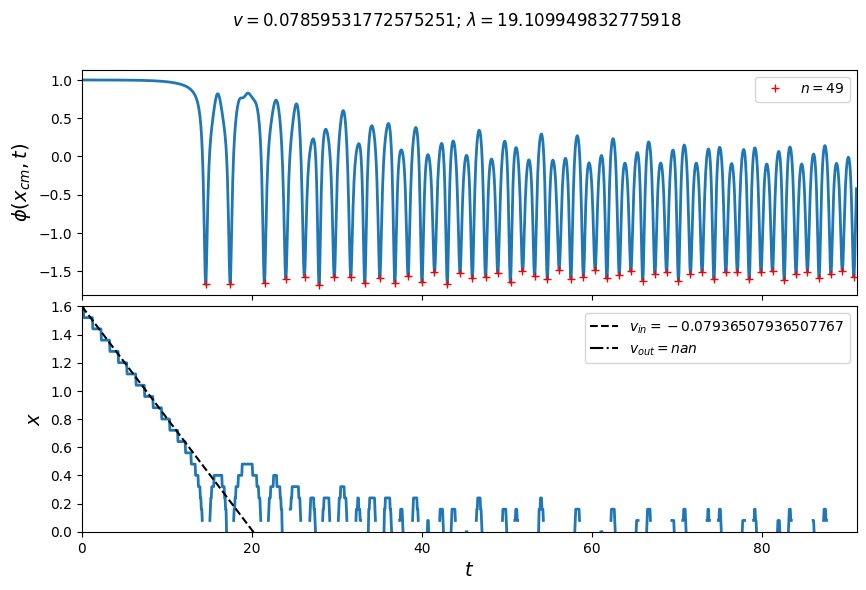

In [18]:
sample = summary.sample(1).iloc[0]
y_cm, trail = np.genfromtxt(sample.path, delimiter=',').T
dx = 2*info.L/info.N
dt = info.dtdx*dx

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'hspace':0.05})

t = np.arange(len(y_cm))*dt
ax1.plot(t, y_cm, lw=2)
ax2.plot(t, trail, lw=2)

peaks, _ = find_peaks(1 - y_cm, prominence=0.5)
ax1.plot(peaks*dt, y_cm[peaks], 'r+', label=r'$n=%s$'%len(peaks))
ax1.legend()

v_in, v_out = velocity(trail, dt)

ax2.plot(t, trail[0] + v_in*t, 'k--', label=r'$v_{in}=%s$'%v_in)
ax2.plot(t, trail[-1] + v_out*(t - len(trail)*dt), 'k-.', label=r'$v_{out}=%s$'%v_out)
ax2.legend()

ax2.set_ylim(0, np.nanmax(trail))
ax2.set_xlim(0, len(trail)*dt)

fig.suptitle(r'$v={}$; $\lambda={}$'.format(*sample.path.stem.split('-')[:2]))

ax1.set_ylabel(r'$\phi(x_{cm}, t)$')
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$x$')
plt.show()

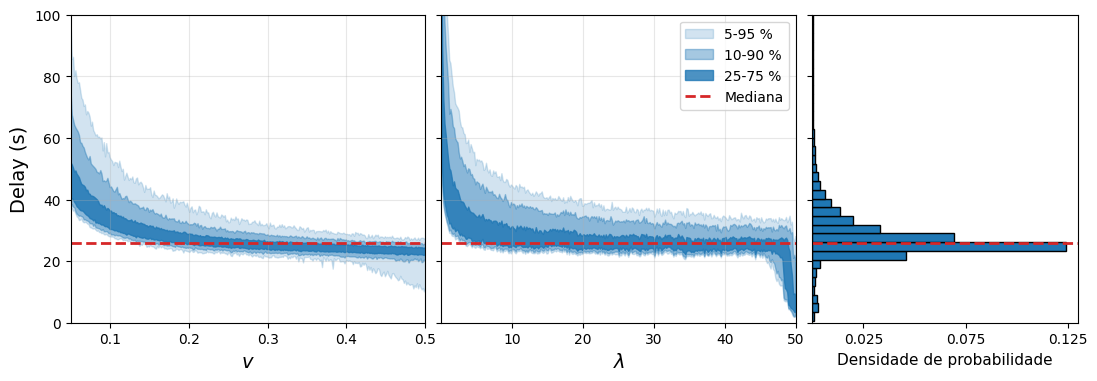

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4), sharey=True, gridspec_kw={'wspace': 0.05, 'width_ratios':[2, 2, 1.5]})

x_label = {'v': r'$v$', 'lamb': r'$\lambda$'}
for col, ax in zip(('v', 'lamb'), axs):

    plot_series_percentile(summary, col, 'delay', ax=ax, color='C0')

    x_lims = summary[col].min(), summary[col].max()
    ax.hlines(summary.delay.median(), *x_lims, linestyles='dashed', color='C3', lw=2, label='Mediana')

    ax.set_xlim(*x_lims)
    ax.set_xlabel(x_label[col])
    ax.grid(alpha=0.3)

axs[-1].hist(summary.delay, bins=150, density=True, edgecolor='k', orientation='horizontal')
axs[-1].hlines(summary.delay.median(), 0, 0.2, linestyles='dashed', color='C3', lw=2, label='Mediana')
axs[-1].set_xlim(0, 0.13)
axs[-1].set_xticks(axs[-1].get_xticks()[1::2])
axs[-1].set_xlabel('Densidade de probabilidade', fontsize=11)

axs[0].set_ylabel('Delay (s)')
axs[1].set_ylim(0, 100)
axs[1].legend() #bbox_to_anchor=(1.26, 1))

plt.show()

0.4028224281385254 [0.00013718]
0.3949284899190444 0.6529356124388044 [0.00035214 0.0268418 ]


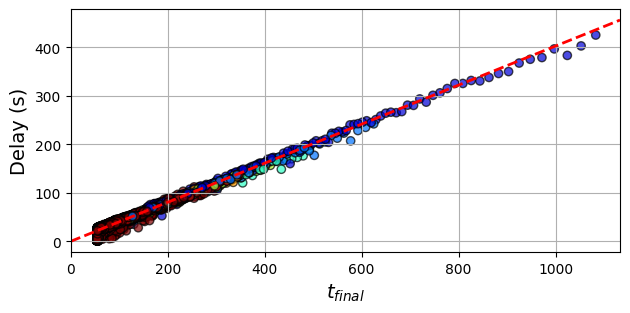

In [20]:
summary['t_final'] = (info.sep_by_delta/summary.v)*np.sqrt(2/summary.lamb) + info.L
plt.scatter(summary.t_final, summary.delay, marker='o', alpha=0.7, edgecolor='k', c=plt.cm.jet(summary.lamb))

(a, ), pcov = curve_fit(lambda x, a: a*x, summary.t_final, summary.delay)
print(a, np.sqrt(np.diag(pcov)))
(b, c), pcov = curve_fit(lambda x, a, b: a*x + b, summary.t_final, summary.delay)
print(b, c, np.sqrt(np.diag(pcov)))

T_max = summary.t_final.max() + 50
X = np.linspace(0, T_max, 50)
plt.plot(X, a*X, 'r--', lw=2)
# plt.plot(X, b*X + c, '--', c='orange', lw=2)
plt.xlim(0, T_max)

plt.xlabel(r'$t_{final}$')
plt.ylabel('Delay (s)')
plt.grid()
plt.gca().set_aspect('equal')
plt.gcf().tight_layout()
plt.show()

In [ ]:
class ArrayBuilder:
    def __init__(self, dtype: np.dtype, shape: tuple):
        self.dtype = dtype
        self.shape = shape
        self._shared_array = mp.RawArray(np.ctypeslib.as_ctypes_type(dtype), int(np.prod(shape)))
    
    def to_numpy(self):
        return np.frombuffer(self._shared_array, dtype=self.dtype).reshape(self.shape)

In [61]:
spath = Path('data/mosaic/')

def mv(filename):
    y_cm, trail = np.genfromtxt(spath/filename, delimiter=',').T
    pd.DataFrame({
        'y_cm': y_cm,
        'trail': trail
    }).to_csv(
        spath/'session-'/filename,
        index= False,
        header= False
    )

with mp.Pool(processes=30) as pool:
    pool.map(mv, [path.name for path in spath.glob('*.csv')])

In [25]:
! ls

LICENSE    data     notebooks  requirements.txt
README.md  modules  reports    scripts


In [28]:
def rm(path):
    try: path.unlink()
    except NotADirectoryError: pass

with mp.Pool(processes=30) as pool:
    pool.map(rm, tuple(Path('data/mosaic/').glob('*.csv')))

: 

In [ ]:
%%time
vs = np.linspace(*Config.v_lims, 300)
lambs = np.linspace(*Config.lamb_lims, 300)
len_summary = len(summary)

counter = mp.Value('i', 0)
shared_mosaic = ArrayBuilder(np.float64, (300, 300, 4))
def calc_mosaic(row):
    mosaic = shared_mosaic.to_numpy()
    path, v, lamb = row[:3]
    with counter.get_lock():
        counter.value += 1
        print(f'\r{(counter.value/len_summary*100):.2f}% - v={v} - lamb={lamb}', end='')
    y_cm, trail = np.genfromtxt(path, delimiter=',').T
    i, j = np.squeeze(np.argwhere(vs == v)), np.squeeze(np.argwhere(lambs == lamb))
    v_in, v_out = velocity(trail)
    mosaic[i, j, 0] = y_cm[-1]
    mosaic[i, j, 1] = v_in
    mosaic[i, j, 2] = v_out
    mosaic[i, j, 3] = len(find_peaks(1 - y_cm, prominence=0.5)[0])


with mp.Pool(processes=30) as pool:
    pool.map(calc_mosaic, summary.values)

0.01% - v=0.21103678929765884 - lamb=15.770484949832774

100.00% - v=0.4187290969899665 - lamb=40.98344481605350625CPU times: user 24.6 s, sys: 10.9 s, total: 35.5 s
Wall time: 1min 14s


In [ ]:
mosaic = shared_mosaic.to_numpy()
mosaic.shape

(300, 300, 4)

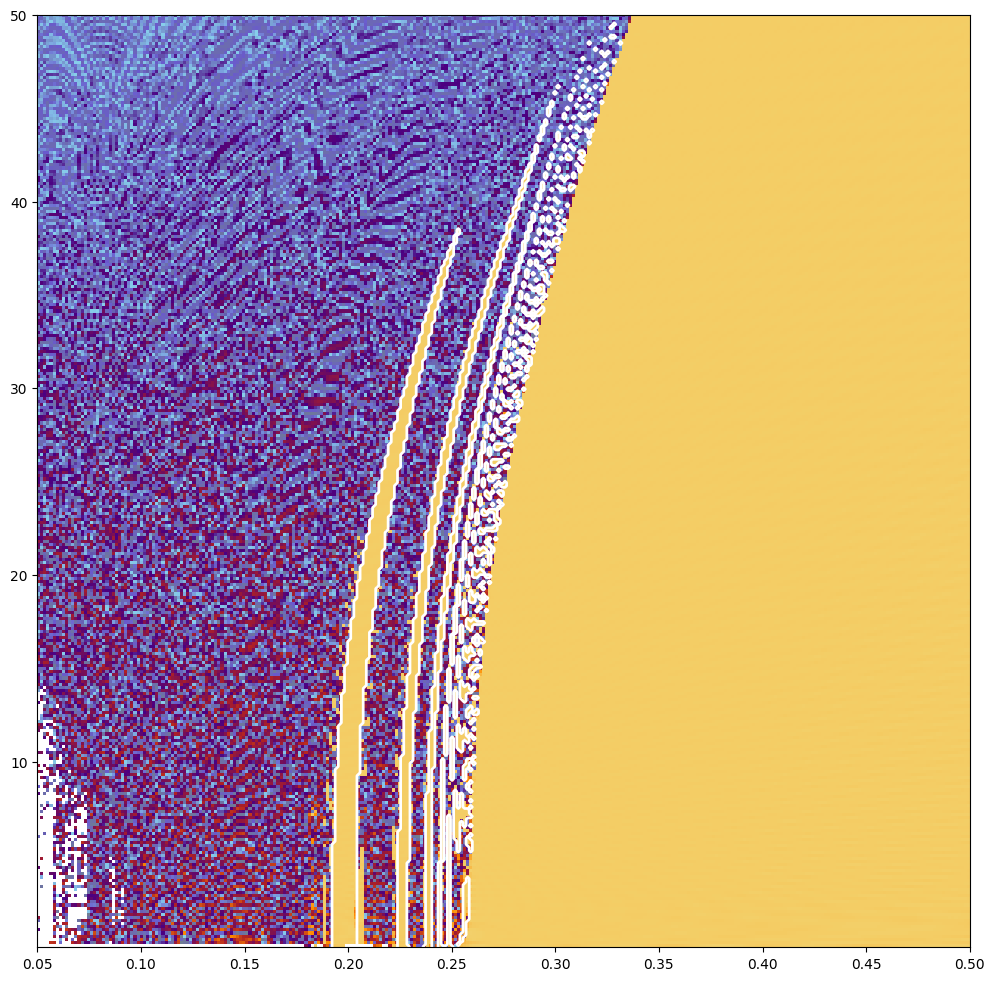

In [715]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(mosaic[..., 0].T, 
    extent=(*Config.v_lims, *Config.lamb_lims), 
    cmap=cmap,
    aspect=(Config.v_max - Config.v_min)/(Config.lamb_max - Config.lamb_min), 
    origin='lower', 
    resample=False,
    vmin=-1.7, vmax=1.5
)
plt.contour(*np.meshgrid(vs, lambs), mosaic[..., 3].T == 2, colors='w', linewidths=2)
fig.tight_layout()
plt.show()

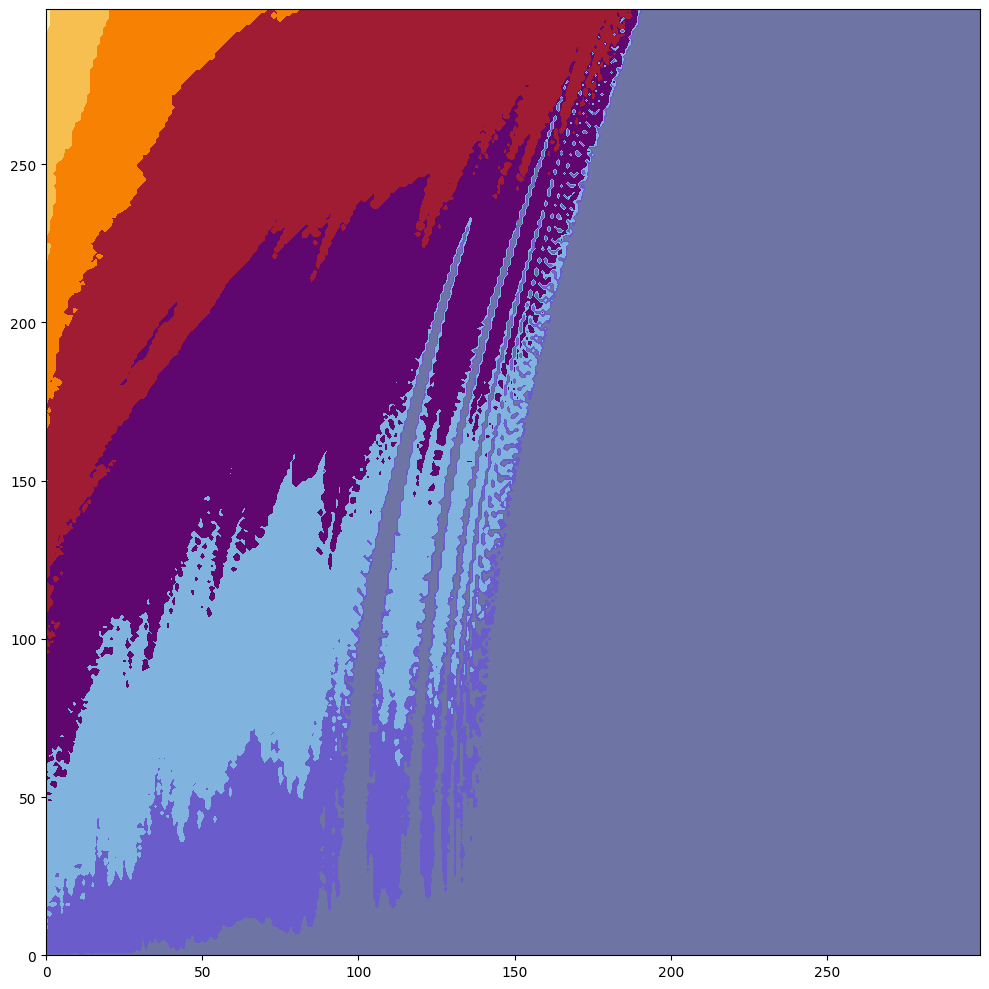

In [718]:
fig = plt.figure(figsize=(10, 10))
plt.contourf(mosaic[..., 3].T, cmap=cmap)
fig.tight_layout()
plt.show()

In [40]:
from math import factorial

In [74]:
alpha = np.r_[-3, -2, -1, 0, 1, 2][:, np.newaxis]
p = len(alpha)
M = alpha**np.arange(p)
m = 2
factorial(m)*np.linalg.inv(M)[m]

array([ 2.59052039e-16, -8.33333333e-02,  1.33333333e+00, -2.50000000e+00,
        1.33333333e+00, -8.33333333e-02])

In [102]:
dp

1

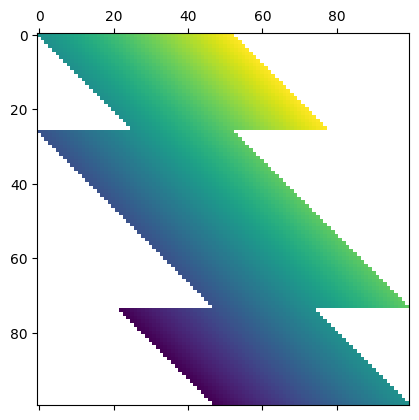

In [121]:
p = 53
dp = 1 if p%2 else 0
a = np.arange(p)
b = a - p//2
c = -a[::-1]
n = 100
D = np.full((n, n), np.nan)
for i in range(n):
    try: D[i, i-p//2:i+p//2+dp] = b
    except:
        try: D[i, i:i+p] = a
        except: D[i, i-p+dp:i+dp] = c
plt.matshow(D)

In [4]:
t_final = 100
y = SessionConfig.collider.collide((-5, 5), (0.25, -0.25), 2, t_final=t_final)

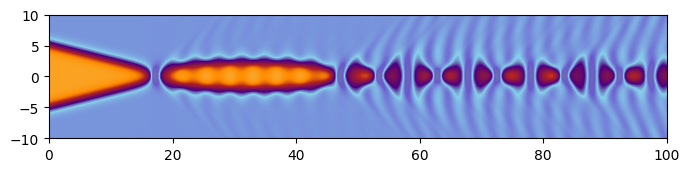

In [5]:
plt.figure(figsize=(7, 7))
plt.imshow(y.T, cmap=cmap, vmin=-2, vmax=2, extent=(0, t_final, -SessionConfig.L, SessionConfig.L), origin='lower')
plt.ylim(-10, 10)
plt.gcf().tight_layout()

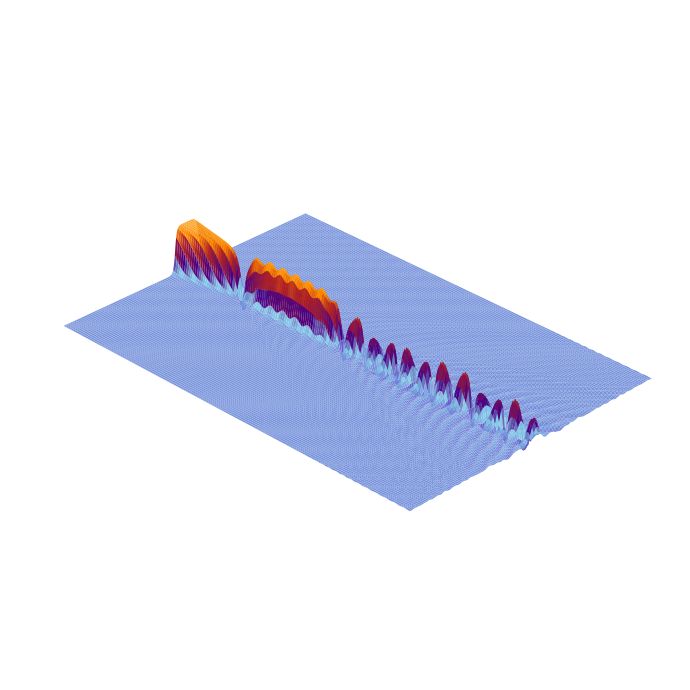

In [7]:
fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(111, projection='3d')
ax.axis('off')

scale = 100
ax.plot_surface(*np.meshgrid(*[np.arange(n) for n in y.shape[::-1]]), y*scale, 
                cmap=cmap, rstride=3, cstride=3, linewidth=1, alpha=1, 
                vmin=-2*scale, vmax=2*scale)

ax.view_init(30, 45, 0)
ax.set_aspect('equal')

fig.tight_layout()

In [14]:
import psutil
import pandas as pd

In [15]:
for k, v in psutil.sensors_temperatures().items(): print(k); print(pd.DataFrame(v))

enp7s0
             label  current  high critical
0  PHY Temperature   63.207  None     None
1  MAC Temperature   69.474  None     None
nvme
       label  current    high  critical
0  Composite    38.85  117.85    149.85
coretemp
           label  current  high  critical
0   Package id 0     59.0  72.0      82.0
1        Core 11     54.0  72.0      82.0
2        Core 16     53.0  72.0      82.0
3        Core 17     53.0  72.0      82.0
4        Core 18     52.0  72.0      82.0
5        Core 19     56.0  72.0      82.0
6        Core 20     55.0  72.0      82.0
7        Core 24     55.0  72.0      82.0
8        Core 25     57.0  72.0      82.0
9        Core 26     54.0  72.0      82.0
10       Core 27     54.0  72.0      82.0
11        Core 0     52.0  72.0      82.0
12        Core 1     51.0  72.0      82.0
13        Core 2     58.0  72.0      82.0
14        Core 3     56.0  72.0      82.0
15        Core 4     56.0  72.0      82.0
16        Core 8     55.0  72.0      82.0
17        Core

In [1]:
import numpy as np

In [4]:
vmin = 0
vmax = 118
spacing = 0.17
len(np.arange(vmin, vmax, spacing)), int((vmax-vmin)/spacing)

(695, 694)

In [60]:
mesh = np.stack(np.meshgrid(*[np.random.rand(10)]*2), axis=-1)
np.sum([np.any((mesh - p) == 0) for p in mesh.reshape((-1, 2))])

100

In [23]:
np.sum(np.isin(np.linspace(1, 5, 300), np.linspace(1, 5, 599)))

300